# Reconstrucción de la Curva de Tipos de Interés

Este notebook implementa la reconstrucción de la curva de tipos de interés (ETTI) usando bonos del Tesoro de Estados Unidos mediante:

1. **Bootstrapping** para obtener tasas spot a partir de precios de mercado
2. **Modelo Nelson-Siegel** para ajustar una curva suave a los datos observados

## Metodología

El proceso consta de dos etapas principales:
- **Bootstrapping**: Construcción de la curva spot a partir de bonos zero-coupon y bonos con cupón
- **Calibración Nelson-Siegel**: Ajuste de una curva paramétrica usando mínimos cuadrados ordinarios (OLS)


In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from scipy.optimize import least_squares


## 1. Carga de Datos

Cargamos el archivo Excel con las cotizaciones de bonos del Tesoro de Estados Unidos.


In [96]:
file_path = "GovernmentBondPrices_UnitedStates.xlsx"
df = pd.read_excel(file_path)


## 2. Normalización de Columnas

Renombramos las columnas para facilitar el procesamiento.


In [97]:
df = df.rename(columns={
    "Cpn": "Coupon_rate",
    "Mat Date": "Maturity_Date",
    "Date": "Valuation_Date"
})


## 3. Conversión de Precios US (Formato 32nds)

Los bonos con cupón del Tesoro de Estados Unidos cotizan en formato de puntos y treintaidosavos. Por ejemplo:
- `99*19` = 99 + 19/32 = 99.59375
- `98*28¾` = 98 + 28.75/32 = 98.8984

**Fórmula de conversión:**
$$P_{decimal} = P_{entero} + \frac{P_{32avos} + P_{fracción}}{32}$$

donde $P_{fracción}$ puede ser 0, ¼, ½, ¾, etc.


In [98]:
UNICODE_FRACTIONS = {
    '¼': 0.25, '½': 0.5, '¾': 0.75,
    '⅛': 0.125, '⅜': 0.375,
    '⅝': 0.625, '⅞': 0.875
}

def us_price_to_decimal(price):
    if isinstance(price, (int, float)):
        return float(price)
    try:
        main, frac = price.split('*')
        integer = float(main)
        match = re.match(r"(\d+)(.*)", frac)
        thirty = int(match.group(1))
        remainder = match.group(2)
        extra = UNICODE_FRACTIONS.get(remainder, 0.0)
        return integer + (thirty + extra) / 32
    except:
        return np.nan


## 4. Normalización de Cupones

Normalizamos las tasas de cupón para que estén en porcentaje (0-100). Si el valor es ≤ 1, asumimos que está en decimal y lo multiplicamos por 100.


## 4. Normalización de Cupones

Normalizamos las tasas de cupón para que estén en porcentaje (0-100). Si el valor es ≤ 1, asumimos que está en decimal y lo multiplicamos por 100.


In [99]:
def normalize_coupon(c):
    if pd.isna(c):
        return 0.0
    if isinstance(c, str):
        c = c.replace('%', '').strip()
    c = float(c)
    return c * 100 if c <= 1 else c

df["Coupon_rate"] = df["Coupon_rate"].apply(normalize_coupon)


## 5. Detección del Tipo de Cotización

Los datos pueden estar cotizados en **precio** o en **yield**. Detectamos el tipo:
- Si contiene `*`, es precio en formato 32nds
- Si el valor numérico < 30, probablemente es yield (%)
- Si el valor ≥ 30, probablemente es precio


## 6. Tiempo hasta Vencimiento

Calculamos el tiempo hasta vencimiento en años usando días exactos:

$$T = \frac{\text{Días hasta vencimiento}}{365.25}$$

Usamos 365.25 para tener en cuenta los años bisiestos.


In [100]:
def detect_quote_type(x):
    if isinstance(x, str) and '*' in x:
        return "Price"
    try:
        val = float(x)
        return "Yield" if val < 30 else "Price"
    except:
        return np.nan

df["Bid_type"] = df["Bid"].apply(detect_quote_type)
df["Ask_type"] = df["Ask"].apply(detect_quote_type)

df["Quote_type"] = np.where(
    (df["Bid_type"] == "Yield") | (df["Ask_type"] == "Yield"),
    "Yield",
    "Price"
)

df.loc[df["Quote_type"] == "Price", "Quoted_value"] = (
    df.loc[df["Quote_type"] == "Price", ["Bid", "Ask"]]
      .map(us_price_to_decimal)
      .mean(axis=1)
)

df.loc[df["Quote_type"] == "Yield", "Quoted_value"] = (
    df.loc[df["Quote_type"] == "Yield", ["Bid", "Ask"]]
      .astype(float)
      .mean(axis=1)
)


In [101]:
df["Maturity_Date"] = pd.to_datetime(df["Maturity_Date"])
df["Valuation_Date"] = pd.to_datetime(df["Valuation_Date"])
df["T"] = (df["Maturity_Date"] - df["Valuation_Date"]).dt.days / 365.25
df = df[df["T"] > 0]


## 7. Clasificación de Instrumentos

Clasificamos los instrumentos en:
- **Zero**: Bonos zero-coupon (cupón = 0%)
- **Coupon**: Bonos con cupón (cupón > 0%)

Esta clasificación es importante porque el proceso de bootstrapping difiere según el tipo de instrumento.

El bootstrapping construye la curva de tasas spot a partir de los precios de mercado. El proceso depende del tipo de instrumento:

### 8.1 Bonos Zero-Coupon

**Si cotiza en yield:**
$$r(T) = \frac{YTM}{100}$$

**Si cotiza en precio:**
$$r(T) = -\frac{\ln(P/100)}{T}$$

donde $P$ es el precio y $T$ es el tiempo hasta vencimiento.

### 8.2 Bonos con Cupón

**Si cotiza en yield:**
Usamos el YTM directamente como proxy del spot rate (según el enunciado):
$$r(T) = \frac{YTM}{100}$$

**Si cotiza en precio:**
Aplicamos bootstrapping iterativo:

1. Calculamos el valor presente de los cupones conocidos usando spots interpolados:
   $$\text{PV}_{cupones} = \sum_{k=1}^{n-1} c \cdot e^{-r(t_k) \cdot t_k}$$
   
   donde $c$ es el cupón semestral y $r(t_k)$ es el spot rate interpolado en $t_k = k/freq$.

2. Calculamos el spot rate para el último flujo:
   $$P - \text{PV}_{cupones} = (F + c) \cdot e^{-r(T) \cdot T}$$
   
   Despejando:
   $$r(T) = -\frac{\ln\left(\frac{P - \text{PV}_{cupones}}{F + c}\right)}{T}$$
   
   donde $F$ es el valor facial (100) y $c$ es el último cupón.


## 8. Bootstrapping de la Curva Spot

El bootstrapping construye la curva de tasas spot a partir de los precios de mercado. El proceso depende del tipo de instrumento:


In [102]:
df["Instrument_class"] = np.where(df["Coupon_rate"] == 0, "Zero", "Coupon")

clean_df = df[[
    "RIC", "Coupon_rate", "Quoted_value",
    "Quote_type", "T", "Instrument_class"
]].dropna().sort_values("T").reset_index(drop=True)

print("\n" + "="*60)
print("DIAGNÓSTICO DE DATOS")
print("="*60)
print(f"\nTotal de instrumentos después de limpieza: {len(clean_df)}")
print(f"\nPor tipo de instrumento:")
print(clean_df["Instrument_class"].value_counts())
print(f"\nPor tipo de cotización:")
print(clean_df["Quote_type"].value_counts())
print(f"\nBonos con cupón por tipo de cotización:")
if len(clean_df[clean_df["Instrument_class"] == "Coupon"]) > 0:
    print(clean_df[clean_df["Instrument_class"] == "Coupon"]["Quote_type"].value_counts())
print(f"\nRango de vencimientos: {clean_df['T'].min():.2f} - {clean_df['T'].max():.2f} años")
print("="*60 + "\n")



DIAGNÓSTICO DE DATOS

Total de instrumentos después de limpieza: 27

Por tipo de instrumento:
Instrument_class
Zero      20
Coupon     7
Name: count, dtype: int64

Por tipo de cotización:
Quote_type
Yield    20
Price     7
Name: count, dtype: int64

Bonos con cupón por tipo de cotización:
Quote_type
Price    7
Name: count, dtype: int64

Rango de vencimientos: 0.08 - 29.93 años



### 8.1 Bonos Zero-Coupon

**Si cotiza en yield:**
$$r(T) = \frac{YTM}{100}$$

**Si cotiza en precio:**
$$r(T) = -\frac{\ln(P/100)}{T}$$

donde $P$ es el precio y $T$ es el tiempo hasta vencimiento.

### 8.2 Bonos con Cupón

**Si cotiza en yield:**
Usamos el YTM directamente como proxy del spot rate (según el enunciado):
$$r(T) = \frac{YTM}{100}$$

**Si cotiza en precio:**
Aplicamos bootstrapping iterativo:

1. Calculamos el valor presente de los cupones conocidos usando spots interpolados:
   $$\text{PV}_{cupones} = \sum_{k=1}^{n-1} c \cdot e^{-r(t_k) \cdot t_k}$$
   
   donde $c$ es el cupón semestral y $r(t_k)$ es el spot rate interpolado en $t_k = k/freq$.

2. Calculamos el spot rate para el último flujo:
   $$P - \text{PV}_{cupones} = (F + c) \cdot e^{-r(T) \cdot T}$$
   
   Despejando:
   $$r(T) = -\frac{\ln\left(\frac{P - \text{PV}_{cupones}}{F + c}\right)}{T}$$
   
   donde $F$ es el valor facial (100) y $c$ es el último cupón.


In [103]:
spot_curve_list = []
spot_curve_dict = {}

def interp_spot(t):
    if not spot_curve_dict:
        return 0.0
    Ts = np.array(sorted(spot_curve_dict.keys()))
    rs = np.array([spot_curve_dict[x] for x in Ts])
    if t <= Ts[0]:
        return rs[0]
    if t >= Ts[-1]:
        return rs[-1]
    return np.interp(t, Ts, rs)

for _, row in clean_df.iterrows():
    T = row["T"]
    P = row["Quoted_value"]
    cpn = row["Coupon_rate"]

    if row["Instrument_class"] == "Zero":
        if row["Quote_type"] == "Yield":
            r = P / 100
        else:
            r = -np.log(P / 100) / T
        spot_curve_list.append((T, r, "Zero"))
        if T in spot_curve_dict:
            spot_curve_dict[T] = (spot_curve_dict[T] + r) / 2
        else:
            spot_curve_dict[T] = r
        continue

    face = 100
    freq = 2
    c = face * cpn / 100 / freq
    n = int(np.round(T * freq))
    
    if row["Quote_type"] == "Yield":
        r_T = P / 100
        spot_curve_list.append((T, r_T, "Coupon"))
        if T in spot_curve_dict:
            spot_curve_dict[T] = (spot_curve_dict[T] + r_T) / 2
        else:
            spot_curve_dict[T] = r_T
        continue
    
    pv_known = 0.0
    for k in range(1, n):
        t = k / freq
        if t < T:
            r_t = interp_spot(t)
            pv_known += c * np.exp(-r_t * t)
    
    pv_final = P - pv_known
    
    if pv_final > 0 and pv_final < (face + c) * 2:
        r_T = -np.log(pv_final / (face + c)) / T
        spot_curve_list.append((T, r_T, "Coupon"))
        if T in spot_curve_dict:
            spot_curve_dict[T] = (spot_curve_dict[T] + r_T) / 2
        else:
            spot_curve_dict[T] = r_T


## 9. Creación del DataFrame de Spots

Una vez completado el bootstrapping, creamos un DataFrame con todos los spots generados. Este DataFrame contiene todos los puntos observados (no solo uno por vencimiento), lo cual es importante para la calibración del modelo Nelson-Siegel.


In [104]:
boot_df = pd.DataFrame(spot_curve_list, columns=["T", "Spot", "Instrument_type"]).sort_values("T")

print("\n" + "="*60)
print("RESULTADOS DEL BOOTSTRAPPING")
print("="*60)
print(f"\nTotal de spots generados: {len(boot_df)}")
print(f"\nSpots únicos por T: {boot_df['T'].nunique()}")
print(f"\nRango de vencimientos con spots: {boot_df['T'].min():.2f} - {boot_df['T'].max():.2f} años")
print(f"\nRango de spot rates: {boot_df['Spot'].min()*100:.4f}% - {boot_df['Spot'].max()*100:.4f}%")
print("="*60 + "\n")



RESULTADOS DEL BOOTSTRAPPING

Total de spots generados: 27

Spots únicos por T: 22

Rango de vencimientos con spots: 0.08 - 29.93 años

Rango de spot rates: 3.4450% - 5.1498%



## 10. Calibración del Modelo Nelson-Siegel (Método OLS)

El modelo Nelson-Siegel parametriza la curva de tipos de interés mediante:

$$y(\tau) = \beta_0 + \beta_1 \cdot f_1(\tau) + \beta_2 \cdot f_2(\tau)$$

donde las funciones de carga son:

$$f_1(\tau) = \frac{1 - e^{-\tau/\lambda}}{\tau/\lambda}$$

$$f_2(\tau) = f_1(\tau) - e^{-\tau/\lambda} = \frac{1 - e^{-\tau/\lambda}}{\tau/\lambda} - e^{-\tau/\lambda}$$

### Interpretación de los parámetros:

- **$\beta_0$ (Level)**: Nivel asintótico de la curva (tasa de largo plazo)
- **$\beta_1$ (Slope)**: Pendiente de la curva (diferencia entre corto y largo plazo)
- **$\beta_2$ (Curvature)**: Curvatura o "joroba" en el medio plazo
- **$\lambda$ (Decay)**: Parámetro de decaimiento que controla la velocidad de transición

### Método de Estimación: Grid Search + OLS

Como el modelo es **lineal en $\beta$ pero no lineal en $\lambda$**, usamos:

1. **Grid search** sobre $\lambda$ en el rango [0.1, 5.0]
2. Para cada $\lambda$, estimamos $\beta$ mediante **mínimos cuadrados ordinarios (OLS)**

El modelo se puede escribir en forma matricial:

$$\mathbf{y} = \mathbf{X}\boldsymbol{\beta} + \mathbf{u}$$

donde:
- $\mathbf{y}$ es el vector de spots observados
- $\mathbf{X} = [\mathbf{1}, \mathbf{f}_1, \mathbf{f}_2]$ es la matriz de diseño
- $\boldsymbol{\beta} = [\beta_0, \beta_1, \beta_2]^T$ son los parámetros a estimar

La solución OLS es:

$$\hat{\boldsymbol{\beta}} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}$$

Seleccionamos el $\lambda$ que minimiza la suma de errores al cuadrado (SSE):

$$\text{SSE} = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$


In [105]:
def ns_functions(tau, lam):
    ratio = tau / lam
    f1 = np.where(ratio < 1e-10, 1.0, (1 - np.exp(-ratio)) / ratio)
    f2 = f1 - np.exp(-ratio)
    return f1, f2

def nelson_siegel_curve(tau, beta0, beta1, beta2, lam):
    f1, f2 = ns_functions(tau, lam)
    return beta0 + beta1 * f1 + beta2 * f2

tau_obs = boot_df["T"].values
y_obs = boot_df["Spot"].values

lambda_grid = np.linspace(0.1, 5.0, 100)
best_sse = np.inf
best_params = None
best_lam = None

for lam in lambda_grid:
    f1, f2 = ns_functions(tau_obs, lam)
    X = np.column_stack([np.ones_like(tau_obs), f1, f2])
    betas, residuals, rank, s = np.linalg.lstsq(X, y_obs, rcond=None)
    y_fit = X @ betas
    sse = np.sum((y_obs - y_fit)**2)
    
    if sse < best_sse:
        best_sse = sse
        best_params = betas
        best_lam = lam

beta0_ols, beta1_ols, beta2_ols = best_params
y_fit_ols = nelson_siegel_curve(tau_obs, beta0_ols, beta1_ols, beta2_ols, best_lam)
sse_ols = np.sum((y_obs - y_fit_ols)**2)


## 11. Resultados del Método OLS

Mostramos los parámetros estimados del modelo Nelson-Siegel usando el método OLS con grid search sobre lambda.


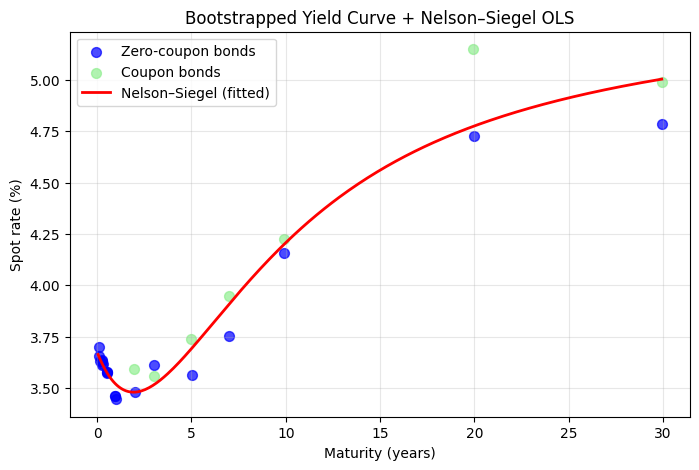

In [106]:
T_grid = np.linspace(0.05, boot_df["T"].max(), 300)
curve = nelson_siegel_curve(T_grid, beta0_ols, beta1_ols, beta2_ols, best_lam)

plt.figure(figsize=(8,5))

zero_bonds = boot_df[boot_df["Instrument_type"] == "Zero"]
coupon_bonds = boot_df[boot_df["Instrument_type"] == "Coupon"]

if len(zero_bonds) > 0:
    plt.scatter(zero_bonds["T"], 100 * zero_bonds["Spot"], 
                color='blue', label="Zero-coupon bonds", alpha=0.7, s=50)

if len(coupon_bonds) > 0:
    plt.scatter(coupon_bonds["T"], 100 * coupon_bonds["Spot"], 
                color='lightgreen', label="Coupon bonds", alpha=0.7, s=50)

plt.plot(T_grid, 100 * curve, label="Nelson–Siegel (fitted)", linewidth=2, color='red')

plt.xlabel("Maturity (years)")
plt.ylabel("Spot rate (%)")
plt.title("Bootstrapped Yield Curve + Nelson–Siegel OLS")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## 10. Resultados de la Calibración

Mostramos los parámetros estimados del modelo Nelson-Siegel y el error de ajuste (SSE).


In [107]:
print("\n" + "="*50)
print("        Nelson–Siegel Calibration Results")
print("="*50)
print("\n[ OLS with Lambda Grid Search ]")
print(f"  • beta₀ (level)     : {beta0_ols:>12.6f}")
print(f"  • beta₁ (slope)     : {beta1_ols:>12.6f}")
print(f"  • beta₂ (curvature) : {beta2_ols:>12.6f}")
print(f"  • λ (decay factor)  : {best_lam:>12.6f}")
print(f"  • SSE               : {sse_ols:>12.6e}")
print("="*50 + "\n")



        Nelson–Siegel Calibration Results

[ OLS with Lambda Grid Search ]
  • beta₀ (level)     :     0.054695
  • beta₁ (slope)     :    -0.017947
  • beta₂ (curvature) :    -0.031421
  • λ (decay factor)  :     2.822222
  • SSE               : 2.776081e-05



## 10. Método Levenberg-Marquardt (LM)

El método **Levenberg-Marquardt (LM)** es un algoritmo diseñado para resolver problemas de mínimos cuadrados no lineales. Combina dos enfoques:

- **Método de Gauss-Newton**: Rápido cuando el modelo está cerca de ser lineal
- **Gradiente descendente**: Más estable y se usa cuando Gauss-Newton falla

### Ventajas sobre OLS:

- Optimiza **todos los parámetros simultáneamente** (incluyendo $\lambda$)
- Puede encontrar mejores soluciones que el grid search
- Usa la solución OLS como punto inicial para mejorar la convergencia

### Implementación:

Usamos `scipy.optimize.least_squares` con el método `'lm'`, definiendo una función de residuos:

$$\text{residuos} = y_{obs} - y(\tau, \beta_0, \beta_1, \beta_2, \lambda)$$


In [108]:
def residuals_ns(params, tau, y):
    beta0, beta1, beta2, lam = params
    if lam <= 0:
        lam = 1e-6
    return y - nelson_siegel_curve(tau, beta0, beta1, beta2, lam)

x0 = np.array([beta0_ols, beta1_ols, beta2_ols, best_lam])

res_lm = least_squares(
    residuals_ns, x0,
    args=(tau_obs, y_obs),
    method='lm',
    max_nfev=2000
)

beta0_lm, beta1_lm, beta2_lm, lam_lm = res_lm.x

y_fit_lm = nelson_siegel_curve(tau_obs, beta0_lm, beta1_lm, beta2_lm, lam_lm)

sse_lm = np.sum((y_obs - y_fit_lm)**2)


## 11. Comparación Numérica: OLS vs Levenberg-Marquardt

Comparación numérica de los parámetros estimados y el error de ajuste (SSE) entre ambos métodos.


In [109]:
print("\n" + "="*60)
print("        Nelson–Siegel Calibration: Method Comparison")
print("="*60)

print("\n[ OLS with Lambda Grid Search ]")
print(f"  • beta₀ (level)     : {beta0_ols:>12.6f}")
print(f"  • beta₁ (slope)     : {beta1_ols:>12.6f}")
print(f"  • beta₂ (curvature) : {beta2_ols:>12.6f}")
print(f"  • λ (decay factor)  : {best_lam:>12.6f}")
print(f"  • SSE               : {sse_ols:>12.6e}")

print("\n[ Levenberg–Marquardt Optimization ]")
print(f"  • beta₀ (level)     : {beta0_lm:>12.6f}")
print(f"  • beta₁ (slope)     : {beta1_lm:>12.6f}")
print(f"  • beta₂ (curvature) : {beta2_lm:>12.6f}")
print(f"  • λ (decay factor)  : {lam_lm:>12.6f}")
print(f"  • SSE               : {sse_lm:>12.6e}")

print("\n[ Differences (LM - OLS) ]")
print(f"  • Δ beta₀           : {beta0_lm - beta0_ols:>12.6f}")
print(f"  • Δ beta₁           : {beta1_lm - beta1_ols:>12.6f}")
print(f"  • Δ beta₂           : {beta2_lm - beta2_ols:>12.6f}")
print(f"  • Δ λ               : {lam_lm - best_lam:>12.6f}")
print(f"  • Δ SSE             : {sse_lm - sse_ols:>12.6e}")
print(f"  • SSE Improvement   : {((sse_ols - sse_lm) / sse_ols * 100):>10.2f}%")

print("\n" + "="*60 + "\n")



        Nelson–Siegel Calibration: Method Comparison

[ OLS with Lambda Grid Search ]
  • beta₀ (level)     :     0.054695
  • beta₁ (slope)     :    -0.017947
  • beta₂ (curvature) :    -0.031421
  • λ (decay factor)  :     2.822222
  • SSE               : 2.776081e-05

[ Levenberg–Marquardt Optimization ]
  • beta₀ (level)     :     0.054636
  • beta₁ (slope)     :    -0.017872
  • beta₂ (curvature) :    -0.031479
  • λ (decay factor)  :     2.798405
  • SSE               : 2.775592e-05

[ Differences (LM - OLS) ]
  • Δ beta₀           :    -0.000059
  • Δ beta₁           :     0.000074
  • Δ beta₂           :    -0.000059
  • Δ λ               :    -0.023818
  • Δ SSE             : -4.890183e-09
  • SSE Improvement   :       0.02%




## 12. Visualización Comparativa: OLS vs Levenberg-Marquardt

Gráfico comparativo mostrando:
- Los datos observados (spots bootstrapped)
- La curva ajustada con OLS
- La curva ajustada con Levenberg-Marquardt
- Diferencias entre ambas curvas


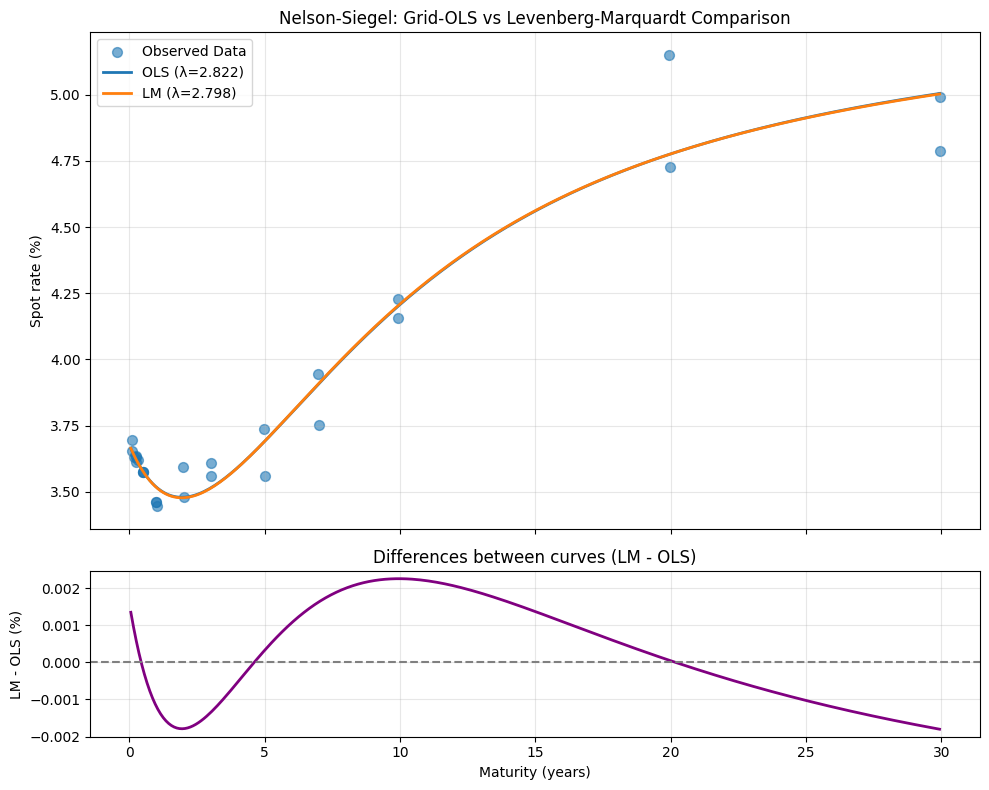

In [110]:
fig, (ax1, ax2) = plt.subplots(
    2, 1, figsize=(10, 8),
    gridspec_kw={'height_ratios': [3, 1]},
    sharex=True
)

T_grid = np.linspace(0.05, boot_df["T"].max(), 300)
curve_ols = nelson_siegel_curve(T_grid, beta0_ols, beta1_ols, beta2_ols, best_lam)
curve_lm = nelson_siegel_curve(T_grid, beta0_lm, beta1_lm, beta2_lm, lam_lm)

zero_bonds = boot_df[boot_df["Instrument_type"] == "Zero"]
coupon_bonds = boot_df[boot_df["Instrument_type"] == "Coupon"]

ax1.scatter(tau_obs, 100 * y_obs, marker='o', label='Observed Data', alpha=0.6, s=50)
ax1.plot(T_grid, 100 * curve_ols, '-', label=f'OLS (λ={best_lam:.3f})', linewidth=2)
ax1.plot(T_grid, 100 * curve_lm, '-', label=f'LM (λ={lam_lm:.3f})', linewidth=2)
ax1.set_ylabel("Spot rate (%)")
ax1.set_title("Nelson-Siegel: Grid-OLS vs Levenberg-Marquardt Comparison")
ax1.grid(True, alpha=0.3)
ax1.legend()

diff = curve_lm - curve_ols
ax2.plot(T_grid, 100 * diff, linewidth=2, color='purple')
ax2.axhline(0, linestyle='--', color='gray')
ax2.set_xlabel("Maturity (years)")
ax2.set_ylabel("LM - OLS (%)")
ax2.set_title("Differences between curves (LM - OLS)")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


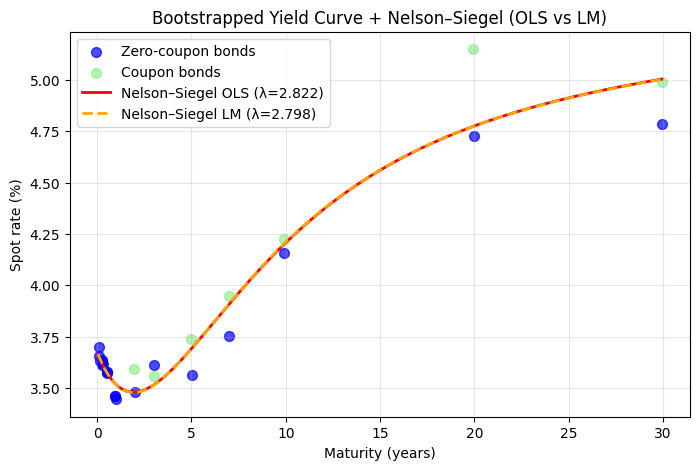

In [111]:
T_grid = np.linspace(0.05, boot_df["T"].max(), 300)
curve_ols = nelson_siegel_curve(T_grid, beta0_ols, beta1_ols, beta2_ols, best_lam)
curve_lm = nelson_siegel_curve(T_grid, beta0_lm, beta1_lm, beta2_lm, lam_lm)

plt.figure(figsize=(8,5))

zero_bonds = boot_df[boot_df["Instrument_type"] == "Zero"]
coupon_bonds = boot_df[boot_df["Instrument_type"] == "Coupon"]

if len(zero_bonds) > 0:
    plt.scatter(zero_bonds["T"], 100 * zero_bonds["Spot"], 
                color='blue', label="Zero-coupon bonds", alpha=0.7, s=50)

if len(coupon_bonds) > 0:
    plt.scatter(coupon_bonds["T"], 100 * coupon_bonds["Spot"], 
                color='lightgreen', label="Coupon bonds", alpha=0.7, s=50)

plt.plot(T_grid, 100 * curve_ols, label=f"Nelson–Siegel OLS (λ={best_lam:.3f})", linewidth=2, color='red', linestyle='-')
plt.plot(T_grid, 100 * curve_lm, label=f"Nelson–Siegel LM (λ={lam_lm:.3f})", linewidth=2, color='orange', linestyle='--')

plt.xlabel("Maturity (years)")
plt.ylabel("Spot rate (%)")
plt.title("Bootstrapped Yield Curve + Nelson–Siegel (OLS vs LM)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## 16. Resultados Finales y Conclusión

Resumen final de los parámetros estimados por ambos métodos y el error de ajuste (SSE). 

### Justificación de la Selección del Método

Basándonos en los resultados, podemos comparar ambos métodos:
- **OLS con Grid Search**: Método robusto y estable, transforma el problema no lineal en una secuencia de problemas lineales.
- **Levenberg-Marquardt**: Optimiza todos los parámetros simultáneamente, puede encontrar soluciones ligeramente mejores pero requiere un buen punto inicial (que proporciona OLS).

En este caso, ambos métodos producen resultados muy similares, lo que indica que la solución OLS ya es muy buena. El método LM proporciona una mejora marginal del SSE.


In [112]:
print("\n" + "="*50)
print("        Nelson–Siegel Calibration Results")
print("="*50)

print("\n[ OLS with Lambda Grid Search ]")
print(f"  • beta₀ (level)     : {beta0_ols:>12.6f}")
print(f"  • beta₁ (slope)     : {beta1_ols:>12.6f}")
print(f"  • beta₂ (curvature) : {beta2_ols:>12.6f}")
print(f"  • λ (decay factor)  : {best_lam:>12.6f}")
print(f"  • SSE               : {sse_ols:>12.6e}")

print("\n[ Levenberg–Marquardt Optimization ]")
print(f"  • beta₀ (level)     : {beta0_lm:>12.6f}")
print(f"  • beta₁ (slope)     : {beta1_lm:>12.6f}")
print(f"  • beta₂ (curvature) : {beta2_lm:>12.6f}")
print(f"  • λ (decay factor)  : {lam_lm:>12.6f}")
print(f"  • SSE               : {sse_lm:>12.6e}")

print("="*50 + "\n")



        Nelson–Siegel Calibration Results

[ OLS with Lambda Grid Search ]
  • beta₀ (level)     :     0.054695
  • beta₁ (slope)     :    -0.017947
  • beta₂ (curvature) :    -0.031421
  • λ (decay factor)  :     2.822222
  • SSE               : 2.776081e-05

[ Levenberg–Marquardt Optimization ]
  • beta₀ (level)     :     0.054636
  • beta₁ (slope)     :    -0.017872
  • beta₂ (curvature) :    -0.031479
  • λ (decay factor)  :     2.798405
  • SSE               : 2.775592e-05



## 13. Visualización Individual (Actualizada)

Visualización de los spots observados junto con ambas curvas ajustadas, diferenciando bonos zero-coupon y con cupón.


In [113]:
boot_df = pd.DataFrame(spot_curve_list, columns=["T", "Spot", "Instrument_type"]).sort_values("T")

print("\n" + "="*60)
print("RESULTADOS DEL BOOTSTRAPPING")
print("="*60)
print(f"\nTotal de spots generados: {len(boot_df)}")
print(f"\nSpots únicos por T: {boot_df['T'].nunique()}")
print(f"\nRango de vencimientos con spots: {boot_df['T'].min():.2f} - {boot_df['T'].max():.2f} años")
print(f"\nRango de spot rates: {boot_df['Spot'].min()*100:.4f}% - {boot_df['Spot'].max()*100:.4f}%")
print("="*60 + "\n")



RESULTADOS DEL BOOTSTRAPPING

Total de spots generados: 27

Spots únicos por T: 22

Rango de vencimientos con spots: 0.08 - 29.93 años

Rango de spot rates: 3.4450% - 5.1498%

